# Тема 15. ПРОЕКТ: Распознавание заболеваний растений по изображению листа. Задание

Болезни растений уже давно являются одной из главных угроз продовольственной безопасности, поскольку они резко снижают урожайность сельскохозяйственных культур и ухудшают их качество. Глобализация торговли вывела вредителей за пределы естественных ареалов обитания, вызвав разрушительные эпидемии в новых регионах. Изменение климата расширило спектр вредителей и патогенов, которые они переносят.

Агрохозяйства стремятся бороться с основными угрозами продовольственной безопасности, автоматизировать такой процесс. Помогите аграриям определять заболевания растений по изображению листа. Мы ограничимся только *томатами*, как наиболее распространенным видом.   




На рисунке ниже вы видите примеры изображений листьев нескольких растений с заболеваниями. 

![img](https://drive.google.com/uc?id=1jKqNTEJwYUsCjjvvVq6B3Zgzrobif4Py)

Данные содержат 6 заболеваний:
* 0 - Tomato Bacterial spot, 
* 1 - Tomato Early blight,
* 2 - Tomato Late blight,
* 3 - Tomato Leaf Mold,
* 4 - Tomato Septoria leaf spot,
* 5 - Tomato Yellow Leaf Curl Virus
* а также изображения здоровых листьев (healthy)

Чтобы решить чем и как обрабатывать растения, важно знать чем они болеют.

На картинках вы видите, что заболевания отличаются друг от друга. Значит можно и автоматизировать процесс распознавания, используя, например, сверточные сети.

Но важно помнить, что реальные изображения могут отличаться от представленных: разные повороты, освещение, масштабы. Необходимо применять аугментацию данных, чтобы лучше обучать сети для реальных применений.





Подключим все необходимые библиотеки:

In [ ]:
# Нейронные сети
import tensorflow as tf
# Предобработка и аугментация
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
# Файловая система
import os
import zipfile 
import shutil
# Рисование
from PIL import Image 
import cv2 
import matplotlib.transforms as tr

# Набор данных
Есть готовый набор данных, в котором содержатся изображения листьев с различными заболеваниями - [PlantVillage](https://www.tensorflow.org/datasets/catalog/plant_village) . В нем довольно много разных растений, мы воспользуемся его сокращенной версией, где оставим только томаты. Это простой набор: все листочки на изображениях отделены, расположены под одним углом, качество съемки замечательное. Это, конечно, хорошо для нейронных сетей, но очень плохо для реальных применений, представьте что в огромном поле нам нужно будет каждый листочек выравнивать, делать хорошее освещение и только поле этого фотографировать его. Не удобно, долго, не эффективно. Поэтому наша цель не просто научиться распознавать заболевания по этому набору, но улучшить распознавание на другие ситуации, когда листок может быть повернут, иметь другое освещение, смещен из центра фотографии.

Выполняем проект по следующему сценарию:

* 1) обучаем нейронную сеть распознаванию заболеваний на этом простом наборе.
* 2) проверяем работу сети в случае, если тестовые изображения изменяются (аугментируются): разные повороты, освещение, смещения.
* 3) дообучаем сеть с аугментированными обучающими данными и проверяем ее работу с аугментированными тестовыми.

Если все сработало - вы прекрасны! Помогли аграриям. 

Вы можете выполнять проект в группах или самостоятельно, соревнуйтесь, кто сможет сделать лучше.



In [ ]:
# Загрузка набора
import gdown # модуль для загрузки с гугл-диска
url = 'https://drive.google.com/uc?id=1ZpbdePYMqT4qXLiI-LQ0o9KK4u3bxuEP' # адрес
output = 'PlantVillage.zip' # название для загружаемого файла
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1ZpbdePYMqT4qXLiI-LQ0o9KK4u3bxuEP
To: /content/PlantVillage.zip
198MB [00:01, 136MB/s]


'PlantVillage.zip'

In [ ]:
# Распакуем
zip_file = 'PlantVillage.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

print(os.listdir())

['.config', 'Plant_Villagev2', 'PlantVillage.zip', 'sample_data']


После загрузки и распаковки получили директорию Plant_Villagev2, содержащую поддиректории с обучающими (train), проверочными (validation) и тестовыми (test) изображениями. Каждый класс изображений находится в своей поддиректории. Это цветные изображения, приведем их к размеру 150*150 пикселей. 

In [ ]:
import os, shutil

base_dir = './Plant_Villagev2'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
classes_list = os.listdir(train_dir)
classes_list

['Tomato_Leaf_Mold',
 'Tomato_Late_blight',
 'Tomato_healthy',
 'Tomato_Early_blight',
 'Tomato_Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus']

# Создание модели
Создайте модель для обучения. Можно выбрать любую архитектуру, какую пожелаете. Можно использовать предобученные сети типа VGG, Inception  и др. Логично использовать не только сверточные слои, но и регуляризации, нормализации и др. 

Ваша цель - сделать лучшую в классе сеть (по метрике accuracy на тестовых данных). **Нельзя изменять тестовые \ проверочные данные** (кроме приведения к диапазону 0..1). Обучающие данные можете изменять по своему желанию (например, выбросить те, на которых плохо обучается, или наоборот, добавить испорченные данные, чтобы сделать более устойчивое к ошибкам обучение), аугментировать их.  

In [ ]:
# Модель
model = tf.keras.models.Sequential([
# Ваш код здесь
])

model.summary()

Функция ошибки и метод обучения.

In [ ]:
model.compile(loss='categorical_crossentropy',
optimizer=# Ваш код здесь
metrics=['acc'])


Создадим объекты ImageDataGenerator для обучающего и проверочного набора. Из аугментаций пока в них сделаем только приведение пикселей к диапазону 0...1 (аргумент rescale=1./255)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = # Ваш код здесь

train_generator = train_datagen.flow_from_directory(
    # Ваш код здесь 
    target_size=(150, 150), 
    # Ваш код здесь
    class_mode='categorical') 

validation_generator = validation_datagen.flow_from_directory(
    # Ваш код здесь
    target_size=(150, 150),
    # Ваш код здесь
    class_mode='categorical')

Found 10043 images belonging to 7 classes.
Found 1881 images belonging to 7 classes.


Обучим модель

In [ ]:
history = model.fit(
    # Ваш код здесь)

Epoch 1/30
230/230 [==============================] - 49s 73ms/step - loss: 1.3459 - acc: 0.6232 - val_loss: 0.8246 - val_acc: 0.8052
Epoch 2/30
230/230 [==============================] - 16s 67ms/step - loss: 0.8300 - acc: 0.7970 - val_loss: 0.7636 - val_acc: 0.8263
Epoch 3/30
230/230 [==============================] - 16s 68ms/step - loss: 0.7279 - acc: 0.8326 - val_loss: 0.6254 - val_acc: 0.8750
Epoch 4/30
230/230 [==============================] - 17s 72ms/step - loss: 0.6799 - acc: 0.8495 - val_loss: 0.5937 - val_acc: 0.8677
Epoch 5/30
230/230 [==============================] - 16s 70ms/step - loss: 0.5896 - acc: 0.8786 - val_loss: 0.5507 - val_acc: 0.8946
Epoch 6/30
230/230 [==============================] - 17s 72ms/step - loss: 0.5542 - acc: 0.9033 - val_loss: 0.5166 - val_acc: 0.9084
Epoch 7/30
230/230 [==============================] - 16s 69ms/step - loss: 0.5564 - acc: 0.8941 - val_loss: 0.5114 - val_acc: 0.9113
Epoch 8/30
230/230 [==============================] - 16s 67ms

In [ ]:
# Сохраним модель
model.save('First_net.h5')

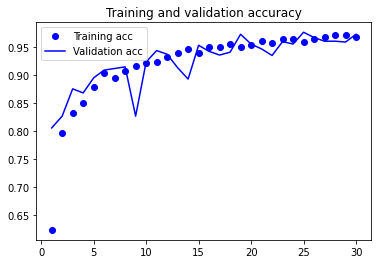

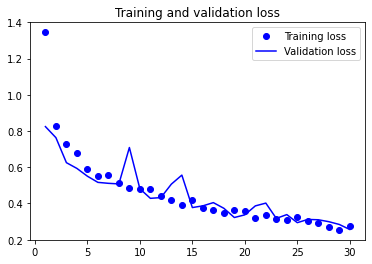

In [ ]:
# Нарисуем
import matplotlib.pyplot as plt

%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Проверим на тестовых данных:

In [ ]:
test_datagen = # Ваш код здесь

test_generator = test_datagen.flow_from_directory(
    # Ваш код здесь
    target_size=(150, 150), 
    # Ваш код здесь
    class_mode='categorical')

Found 625 images belonging to 7 classes.


In [ ]:
score = model.evaluate(test_generator, steps=100, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
print(score)

[0.30125105381011963, 0.9599999785423279]


Получилось весьма не плохо (95%) и без аугментаций, но все же проверим, как будут работать аугментации.

# Аугментация

In [ ]:
# Функция для рисования аугментированных изображений
def plotImages(images_arr,m,n):
    fig, axes = plt.subplots(m, n, figsize=(20,20))
    axes = axes.flatten()
    for ax in axes:
        ax.imshow(images_arr.next()[0][0])
    plt.tight_layout()
    plt.show()

Для аугментации используем:
* изменение яркости (brightness)
* смещения изображения
* поворот изображения
* смещения каналов цветности (channel)

*Тестовые* аугментированные данные. **Изменять тестовые аугментации запрещено**.


In [ ]:
# аугментатор
aug_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range=(.1, 1.5),
    channel_shift_range=110,
    width_shift_range=0.3, 
    height_shift_range=0.3,
    rotation_range=155
)
# тестовые аугментированные данные НЕИЗМЕНЯТЬ
aug_test_generator = aug_datagen.flow_from_directory(
    test_dir, 
    target_size=(150, 150), 
    batch_size=32,
    class_mode='categorical')


Found 625 images belonging to 7 classes.


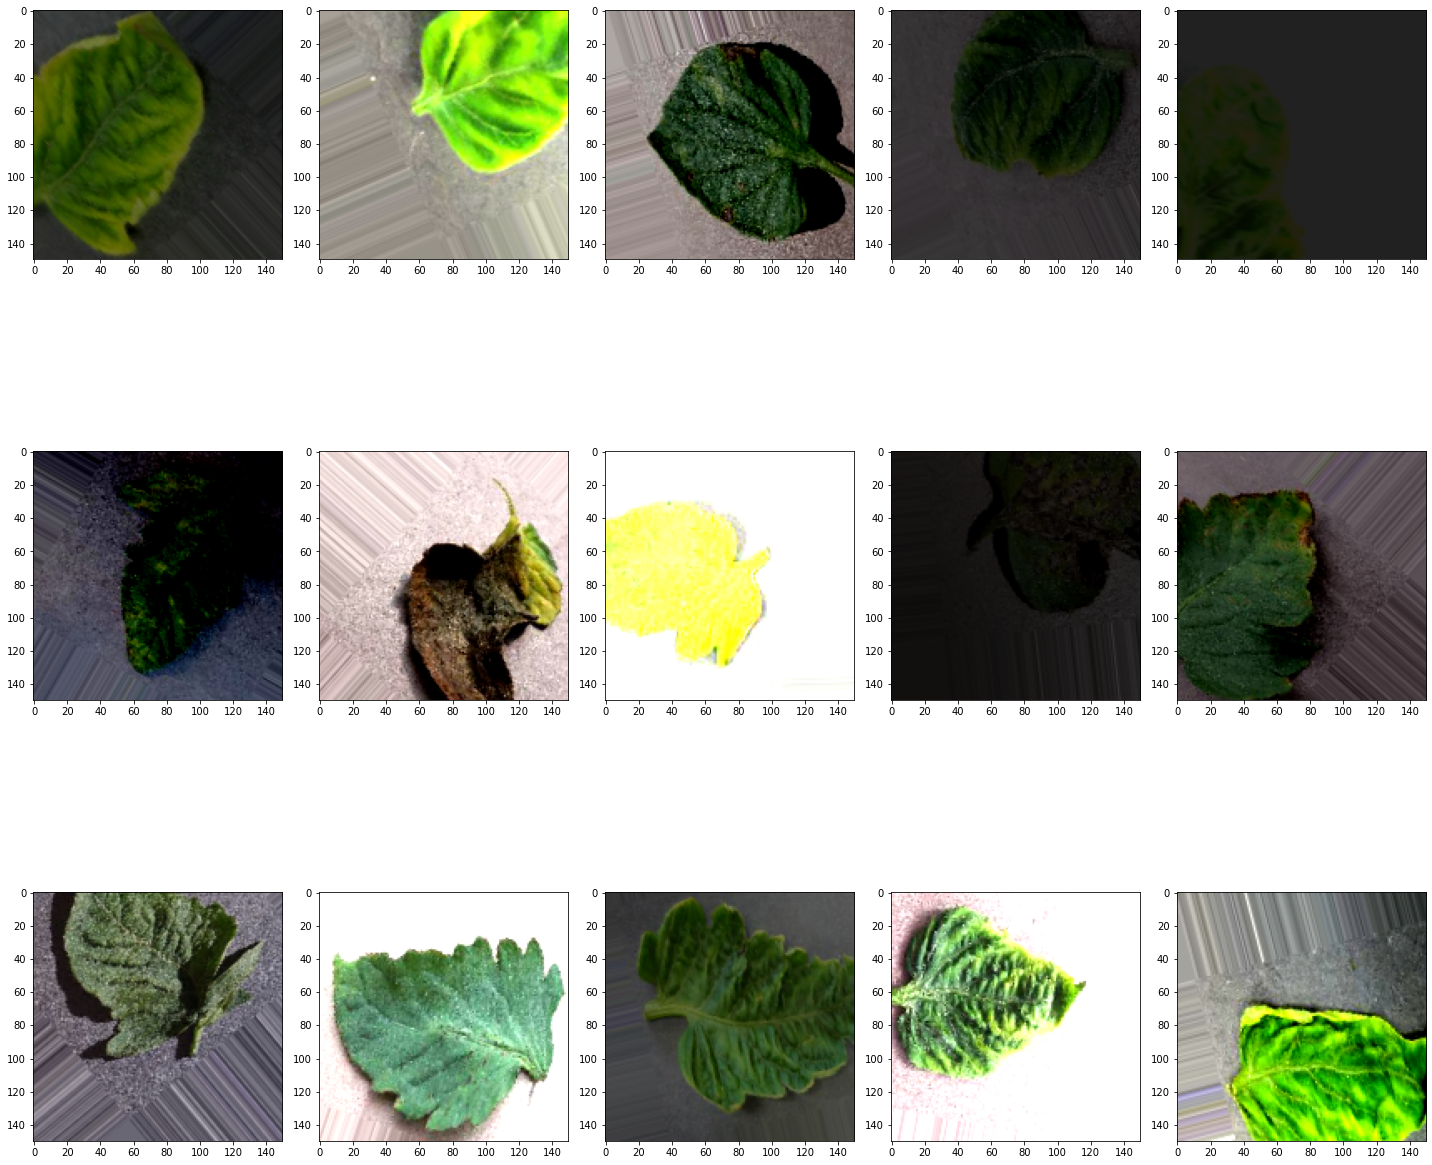

In [ ]:
# Нарисуем несколько
plotImages(aug_test_generator,3,5)

Согласитесь, такие изображения вполне возможно получить на практике. Как будет работать наша обученная сеть, если мы проверим ее на таких аугментированных изображениях? 

In [ ]:
score = # Ваш код здесь
print(score)

[4.208356857299805, 0.42879998683929443]


Ой-ей, все плохо, сеть, обученная на "хороших" изображениях, для не очень хороших аугментированных работает гораздо хуже (~40%). 

Значит надо и в обучении использовать аугментации, переобучить нашу сеть.


Делаем аугментированные обучающий и проверочный наборы. 

In [ ]:
# аугментированные обучающие данные
aug_train_generator = # Ваш код здесь
# аугментированные проверочные данные
aug_val_generator = # Ваш код здесь


Found 10043 images belonging to 7 classes.
Found 1881 images belonging to 7 classes.


Продолжаем обучение нашей сети, но теперь с аугментированными данными.

In [ ]:
history_aug = # Ваш код здесь

Epoch 1/30
230/230 [==============================] - 67s 290ms/step - loss: 1.4443 - acc: 0.6275 - val_loss: 1.1448 - val_acc: 0.7347
Epoch 2/30
230/230 [==============================] - 68s 297ms/step - loss: 1.0994 - acc: 0.7410 - val_loss: 0.9522 - val_acc: 0.7878
Epoch 3/30
230/230 [==============================] - 66s 287ms/step - loss: 0.9979 - acc: 0.7675 - val_loss: 0.8938 - val_acc: 0.8081
Epoch 4/30
230/230 [==============================] - 66s 288ms/step - loss: 0.9063 - acc: 0.7895 - val_loss: 0.7946 - val_acc: 0.8081
Epoch 5/30
230/230 [==============================] - 66s 288ms/step - loss: 0.8079 - acc: 0.8145 - val_loss: 0.7179 - val_acc: 0.8358
Epoch 6/30
230/230 [==============================] - 67s 293ms/step - loss: 0.8076 - acc: 0.8129 - val_loss: 0.7333 - val_acc: 0.8372
Epoch 7/30
230/230 [==============================] - 66s 288ms/step - loss: 0.7696 - acc: 0.8269 - val_loss: 0.7045 - val_acc: 0.8358
Epoch 8/30
230/230 [==============================] - 6

Проверим ее работу на **аугментированных тестовых** данных

In [ ]:
score = # Ваш код здесь

[0.45233047008514404, 0.9071999788284302]


Теперь гораздо лучше (~90%), мы смогли помочь аграриям распознавать болезни растений в более приближенных к реальности ситуациях.

Теперь им не надо выравнивать для фотографирования каждый листочек, точно настраивать фотоаппарат, закрываться от солнышка. 


Продемонструйте ваши результаты всему классу.


# Ссылки
Задания проекта сделаны на основе:
  * Никонов Н.Д. "Математическое моделирование и программная реализация нейронных сетей для
идентификации заболеваний растений", выпускная работа, бакалавриат МФТИ, июнь 2021.  